In [1]:
import pandas as pd
from gensim.models import FastText


C:\Users\Andreas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_hdf("../datasets/Conservative.h5", key="Conservative")

In [3]:
model_sent = FastText.load("../models/subreddit_level/fasttext_Conservative_senti.bin")
#model_weat = FastText.load("models/subreddit_level/fasttext_TwoXChromosomes_weat.bin")

In [4]:
NRC = pd.read_csv('../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])
#NRC.columns = ["Words", "valence", "arousal", "dominance"]

In [5]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [6]:
flatlist_2 = [item for sublist in flatlist for item in sublist]

In [7]:
len(list(set(flatlist_2)))

81940

In [8]:
len(flatlist)

1630382

In [47]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"] 

    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [48]:
woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [49]:
woman_terms_freq, man_terms_freq

([['she', 'woman', 'female', 'her', 'girl', 'daughter', 'sister'],
  [42629, 20117, 1597, 14571, 2652, 1510, 630]],
 [['he', 'his', 'man', 'male', 'boy', 'son', 'brother'],
  [107379, 35314, 18204, 2142, 2325, 1520, 1224]])

In [50]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [51]:
df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)


Top 10 (woman) ['she', 'her', 'herself', 'woman', 'lady', 'daughter', 'sil', 'husband', 'girl', 'catcall']
Top 10 (man) ['he', 'his', 'himself', 'son', 'handler', 'trump', 'guy', 'trumptard', 'joe', 'him']


In [52]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
115,hell,0.020,0.918,0.565
103,hater,0.052,0.702,0.422
149,embarrass,0.082,0.667,0.364
40,dementia,0.092,0.779,0.337
90,bruise,0.133,0.640,0.474


In [53]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
115,hell,0.020,0.918,0.565
245,playboy,0.646,0.900,0.519
232,irate,0.188,0.852,0.474
152,hunter,0.292,0.817,0.817
180,brash,0.360,0.814,0.552


In [54]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
5,president,0.677,0.622,0.973
199,presidential,0.612,0.656,0.972
171,boss,0.310,0.627,0.954
220,leader,0.833,0.582,0.926
15,presidency,0.776,0.686,0.918


In [55]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
111,abused,0.021,0.874,0.235
227,unprofessional,0.042,0.370,0.170
80,deathbed,0.051,0.652,0.311
215,sorrow,0.052,0.235,0.164
22,shame,0.060,0.670,0.155


In [56]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
127,sexy,0.865,0.945,0.802
24,stalker,0.177,0.930,0.639
123,rapist,0.062,0.906,0.571
18,distraught,0.115,0.903,0.264
233,playboy,0.646,0.900,0.519


In [57]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
115,boss,0.310,0.627,0.954
217,superstar,0.885,0.860,0.880
74,doctor,0.700,0.531,0.861
192,queen,0.875,0.692,0.860
189,fame,0.896,0.755,0.852


In [58]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.03884328258754863 0.027135468111624515 0.03135132271400776


In [59]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.051976323893673904 0.034314568740718754 0.024977665265815265


In [60]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df["valence"]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()

    print("kolmogorv", stats.kstest(df[subject],
               stats.norm.cdf))

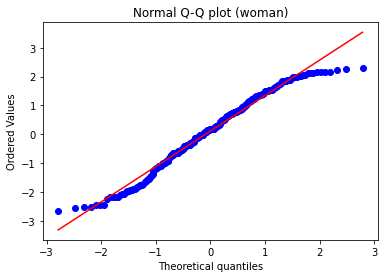

kolmogorv KstestResult(statistic=0.5558671551991252, pvalue=4.043990758121258e-76)


In [61]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

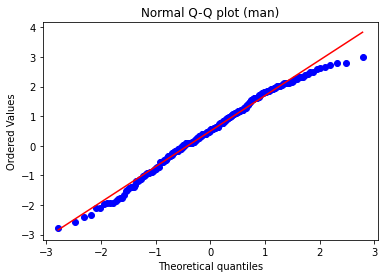

kolmogorv KstestResult(statistic=0.5507507732029859, pvalue=9.43629865553646e-74)


In [62]:
check_normal_dist(df_NRC_man, "arousal","man")

In [63]:
def apply_welch_test(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    import math
    import statistics
   
    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
        
        print(d, "Cohens D")
    print(len(df_1), len(df_2))

In [64]:
apply_welch_test(df_NRC_woman, df_NRC_man,"arousal")
apply_welch_test(df_NRC_woman, df_NRC_man,"valence")
apply_welch_test(df_NRC_woman, df_NRC_man,"dominance")

welsh
Statistics=2.514849, p=0.012
Different distributions (reject H0)
0.221134637870989 Cohens D
260 257
welsh
Statistics=-1.180379, p=0.238
Same distribution (fail to reject H0)
260 257
welsh
Statistics=-1.882673, p=0.060
Same distribution (fail to reject H0)
260 257


In [66]:
print(df_NRC_man["valence"].mean(),df_NRC_man["arousal"].mean(),df_NRC_man["dominance"].mean() )
print(df_NRC_woman["valence"].mean(),df_NRC_woman["arousal"].mean(),df_NRC_woman["dominance"].mean() )

0.5580505836575874 0.4763190661478598 0.5024202334630353
0.5359346153846155 0.5150807692307691 0.474619230769231
